In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

$$\widehat{\sigma}^{2}=\frac{2}{T} \sum_{i} \frac{\Delta K_{i}}{K_{i}^{2}} e^{R T} Q\left(K_{i}\right)-\frac{1}{T}\left[\frac{F}{K_{0}}-1\right]^{2}$$
$$\widehat{V I X_{a}}=\sqrt{\left\{\left[\frac{N\left(T_{2}\right)-N(30)}{N\left(T_{2}\right)-N\left(T_{1}\right)}\right]\left(T_{1} \cdot \widehat{\sigma}_{1}^{2}\right)+\left[\frac{N(30)-N\left(T_{1}\right)}{N\left(T_{2}\right)-N\left(T_{1}\right)}\right]\left(T_{2} \cdot \widehat{\sigma}_{2}^{2}\right)\right\}\left(\frac{N(365)}{N(30)}\right)}$$
其中：
+ $\widehat{\sigma}^{2}$：近月波动率估计；
+ T: 期权合约剩余到期时间；
+ R:时长为T的无风险利率；
+ F：无套利的远期价格，计算步骤如下:
  1. 获取时长为T的无风险利率R；
  2. 获取认购期权价格与认沽期权价格相差最小的执行价，记为S；（注意这里不是标的资产价格）
  3. 计算无套利远期价格，$F = S + e^{RT}(C(S) - P(S))$, 是执行价为S的认购期权价格。
+ $K_0$: 小于F但最靠近F的执行价；
+ $K_i$：从小到大所有近月合约的执行价；
+ $\Delta K_i$：第i个执行价所对应的执行价间隔，一般为$\frac{K_{i+1} - K_{i-1}}{2}$;
+ $Q_{K_i}$：执行价为$K_i$的虚值期权的价格。（即有可能为认购期权，也有可能是认沽期权，保证它为虚值期权！）至于为什么是Q？quote、报价，比较合理吧？
+ N()：代表时间间隔数,$T_1$$T_2$分别代表近月（下一个月），次近月（下下个月）

In [68]:
def prepare_data():
    """提取VIX计算需要的数据"""
    # 期权数据
    opt_basic = pd.read_csv('data/opt_basic.csv')
    opt_price = pd.read_csv('data/opt_price.csv')
    opt_data = pd.merge(opt_price, opt_basic, on='code')

    # 转换为日期格式
    opt_data['date'] = pd.to_datetime(opt_data['date'])
    opt_data['exercise_date'] = pd.to_datetime(opt_data['exercise_date'])
    # 筛选需要的字段

    use_fields = ['date', 'close', 'contract_type', 'exercise_price', 'exercise_date']
    opt_data = opt_data[use_fields]

    # 重命名
    opt_data['contract_type'] = opt_data['contract_type'].map({'CO': 'call', 'PO': 'put'})
    opt_data['T-days'] = (opt_data['exercise_date'] - opt_data['date']).apply(lambda x: x.days)
    opt_data['TTM'] = opt_data['T-days'] / 365

    # 利率数据
    interest_rate = pd.read_csv('data/interest_rate.csv', index_col=0)

    # 转换格式
    interest_rate.index = pd.DatetimeIndex(interest_rate.index)
    interest_rate.columns = interest_rate.columns.astype(int)

    # 填充遗漏天数
    omit_date = list(set(opt_data['date']) - set(interest_rate.index))
    for d in omit_date:
        interest_rate.loc[d, :] = np.nan
    interest_rate = interest_rate.sort_index().ffill()
    return opt_data, interest_rate

opt_data, interest_rate = prepare_data()

In [69]:
for dt, data in opt_data.groupby('date'):
    break
# dt == Timestamp('2015-02-09 00:00:00')
# data见下图
data

,date,close,contract_type,exercise_price,exercise_date,T-days,TTM
0,2015-02-09,0.1826,call,2.20,2015-03-25,44,0.120548
28,2015-02-09,0.1460,call,2.25,2015-03-25,44,0.120548
56,2015-02-09,0.1225,call,2.30,2015-03-25,44,0.120548
84,2015-02-09,0.0942,call,2.35,2015-03-25,44,0.120548
112,2015-02-09,0.0735,call,2.40,2015-03-25,44,0.120548
140,2015-02-09,0.0617,put,2.20,2015-03-25,44,0.120548
168,2015-02-09,0.0777,put,2.25,2015-03-25,44,0.120548
196,2015-02-09,0.0969,put,2.30,2015-03-25,44,0.120548
224,2015-02-09,0.1268,put,2.35,2015-03-25,44,0.120548
252,2015-02-09,0.1542,put,2.40,2015-03-25,44,0.120548


In [70]:
# 筛选近月、次近月的合约存续时间
all_T = data[data['T-days'] > 7]['T-days'].unique()
all_T.sort()
# 以【日】为单位和以【年】为单位的存续时间
Tdays_fm, Tdays_sfm = all_T[:2]
T_fm, T_sfm = all_T[:2] / 365
# 以此筛选出用于计算的合约数据
data_fm, data_sfm = data[data['TTM'] == T_fm], data[data['TTM'] == T_sfm]
data_fm

,date,close,contract_type,exercise_price,exercise_date,T-days,TTM
0,2015-02-09,0.1826,call,2.20,2015-03-25,44,0.120548
28,2015-02-09,0.1460,call,2.25,2015-03-25,44,0.120548
56,2015-02-09,0.1225,call,2.30,2015-03-25,44,0.120548
84,2015-02-09,0.0942,call,2.35,2015-03-25,44,0.120548
112,2015-02-09,0.0735,call,2.40,2015-03-25,44,0.120548
140,2015-02-09,0.0617,put,2.20,2015-03-25,44,0.120548
168,2015-02-09,0.0777,put,2.25,2015-03-25,44,0.120548
196,2015-02-09,0.0969,put,2.30,2015-03-25,44,0.120548
224,2015-02-09,0.1268,put,2.35,2015-03-25,44,0.120548
252,2015-02-09,0.1542,put,2.40,2015-03-25,44,0.120548


In [71]:
def pivot_table_(data):
    data = data.pivot_table(index='exercise_price', columns='contract_type', values='close')
    data['call-put'] = data['call'] - data['put']
    data['abs-diff'] = np.abs(data['call-put'])
    return data


def get_params(data, dt, Tdays):
    """
    参数计算函数.
    data: 前面计算的数据透视表；
    dt: 计算VIX指数的时间；
    Tdays: 到期时间，单位为（日）；
    return:
        S: 无套利标的资产价格
        R: 对应时间的无风险利率
        F: 无套利远期价格
        K0: 离F最近的，但小于F的执行价
        Q: pandas.DataFrame, 里面包含计算参数Q, K_i, delta_K_i
    """
    S = data.sort_values(by='abs-diff').index[0]
    R = interest_rate.loc[dt, Tdays] / 100
    F = S + np.exp(Tdays / 365 * R) * data.loc[S, 'call-put']
    K0 = np.max(data.index[data.index < F])
    # 合约选择
    Q = data[['call', 'put']].copy()
    Q.loc[Q.index >= F, 'Q'] = Q.loc[Q.index >= F, 'call']
    Q.loc[Q.index < F, 'Q'] = Q.loc[Q.index < F, 'put']
    Q = Q['Q'].reset_index()
    # 一大波操作：重设K_i index，移动窗口方法计算delta_K_i
    Q['delta_K'] = Q['exercise_price']\
        .rolling(3, center=True)\
        .apply(lambda x: (x.iloc[-1] - x.iloc[0]) / 2)\
        .ffill().bfill() # 填充两端的缺失值
    return S, R, F, K0, Q

# S_fm, R_fm, F_fm, K0_fm = (2.3, 0.04996766666666667, 2.325754666938786, 2.3)
# S_sfm, R_sfm, F_sfm, K0_sfm = (2.3, 0.049402999999999996, 2.3140361211554956, 2.3)

In [72]:
def get_sigma(T, R, F, K0, Q):
    sigma_part1 = (2/T) * np.sum(np.exp(R*T)*Q['Q']*Q['delta_K']/np.square(Q['exercise_price']))
    sigma_part2 = (1/T) * (F/K0 - 1)**2
    return sigma_part1 + sigma_part2

def get_VIX(sigma1, sigma2, T1, T2):
    vix_part1 = (T1 * sigma1) * (T2 - 30 / 365) / (T2 - T1)
    vix_part2 = (T2 * sigma2) * (30 / 365 - T1) / (T2 - T1)
    return np.sqrt((365 / 30) * (vix_part1 + vix_part2))

In [73]:
# 设置一个空字典来储存数据
VIX = {}
for dt, data in opt_data.groupby('date'):
    # 筛选近月、次近月的合约存续时间
    all_T = data[data['T-days'] > 7]['T-days'].unique()
    all_T.sort()
    T_fm, T_sfm = all_T[:2] / 365
    Tdays_fm, Tdays_sfm = all_T[:2]
    # 以此筛选出用于计算的合约数据
    data_fm, data_sfm = data[data['TTM'] == T_fm], data[data['TTM'] == T_sfm]
    # 数据透视表操作
    data_fm_ = pivot_table_(data_fm.copy())
    data_sfm_ = pivot_table_(data_sfm.copy())
    # 获取计算参数
    S_fm, R_fm, F_fm, K0_fm, Q_fm = get_params(data_fm_, dt, Tdays_fm)
    S_sfm, R_sfm, F_sfm, K0_sfm, Q_sfm = get_params(data_sfm_, dt, Tdays_sfm)
    # 计算sigma
    sigma1 = get_sigma(T_fm, R_fm, F_fm, K0_fm, Q_fm)
    sigma2 = get_sigma(T_sfm, R_sfm, F_sfm, K0_sfm, Q_sfm)
    # 计算VIX指数
    VIX[dt] = get_VIX(sigma1, sigma2, T_fm, T_sfm)

# 里面有一些天数算不出来（但不多），估计是合约移仓换月的时候无数可算。
VIX = pd.Series(VIX, name='VIX').dropna()

# 保存数据
# VIX.to_csv('VIX.csv')

Text(0.5, 1.0, '50 VIX')

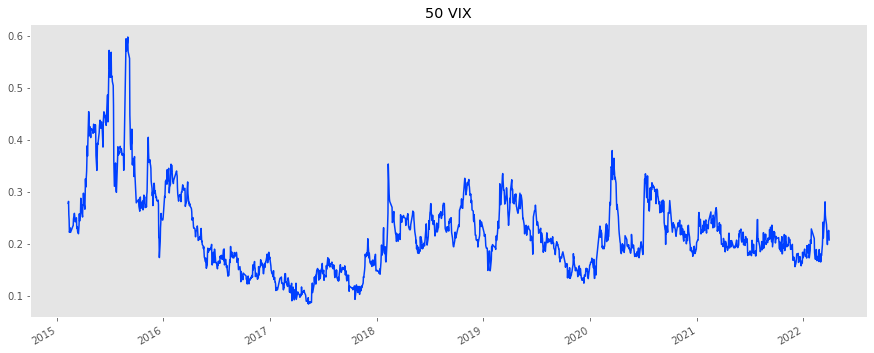

In [74]:
fig, ax = plt.subplots(figsize=(15, 6))
VIX.plot(ax=ax)
ax.grid()
plt.title('50 VIX')
# 保存图像
# plt.savefig('source/VIX.png', bbox_inches='tight', dpi=200)

In [75]:
VIX

2015-02-09    0.277829
2015-02-10    0.281666
2015-02-11    0.256395
2015-02-12    0.246219
2015-02-13    0.222193
                ...   
2022-03-24    0.198685
2022-03-25    0.217745
2022-03-28    0.225862
2022-03-29    0.224700
2022-03-30    0.207566
Name: VIX, Length: 1720, dtype: float64

In [76]:
IV = pd.read_csv('data/IV.csv', index_col=0)
IV = IV.groupby('date').mean()
IV.index.name = None
IV.index = pd.DatetimeIndex(IV.index)
VIX = pd.read_csv('./VIX.csv', index_col=0)
VIX.index = pd.DatetimeIndex(VIX.index)
df = pd.concat([IV, VIX], axis=1)
df

,IV,VIX
2015-02-09,0.340845,0.277829
2015-02-10,0.315312,0.281666
2015-02-11,0.278794,0.256395
2015-02-12,0.266023,0.246219
2015-02-13,0.234964,0.222193
...,...,...
2022-03-24,0.206231,0.198685
2022-03-25,0.220270,0.217745
2022-03-28,0.225740,0.225862
2022-03-29,0.226268,0.224700


Text(0, 0.5, '$VIX$')

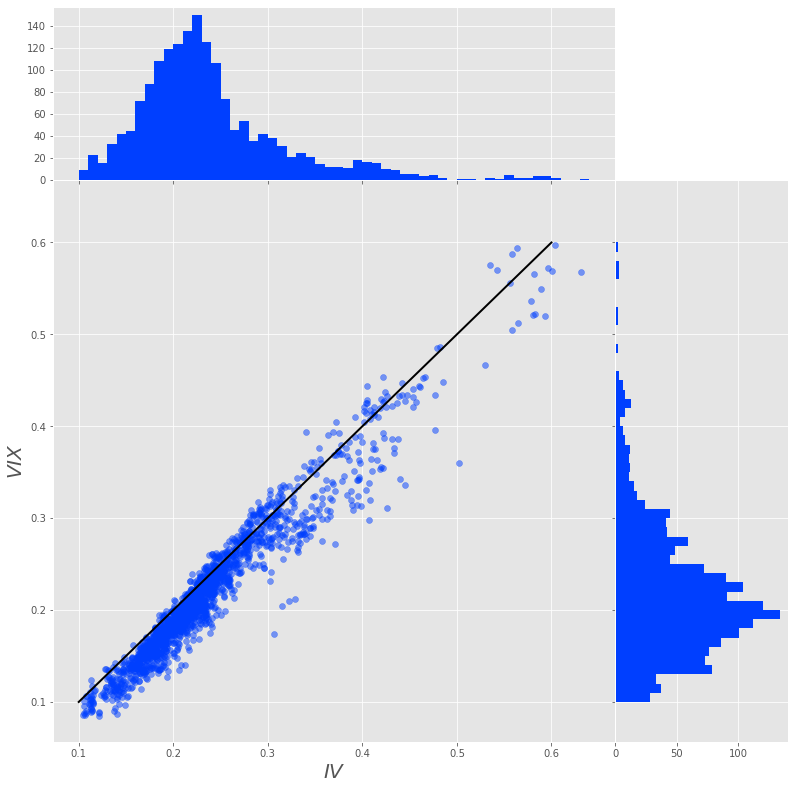

In [77]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, alpha=.5)

    # now determine nice limits by hand:
    binwidth = 0.01
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(0.1, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
    pass

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.0005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(12, 12))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

x, y = df['IV'], df['VIX']
# use the previously defined function
scatter_hist(x, y, ax, ax_histx, ax_histy)
ax.plot([0.1, 0.6], [0.1, 0.6], color='k', lw=2)
ax.set_xlabel('$IV$', fontsize=20)
ax.set_ylabel('$VIX$', fontsize=20)
# 保存图片
# plt.savefig('source/scatter_plot.png', dpi=200, bbox_inches='tight')

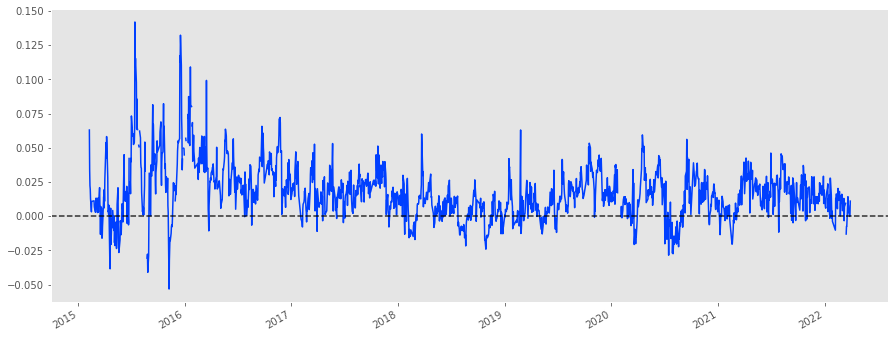

In [79]:
fig, ax = plt.subplots(figsize=(15, 6))
df['spread'] = df['IV'] - df['VIX']
df['spread'].plot()
ax.axhline(y=0, ls='--', c='0', alpha=0.8)
ax.grid()
# 保存图像
# plt.savefig('source/IV-VIX-spread.png', dpi=200, bbox_inches='tight')